In [109]:
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
from safetensors.torch import load_model
from torchvision import transforms
from PIL import Image

In [110]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Image Processing

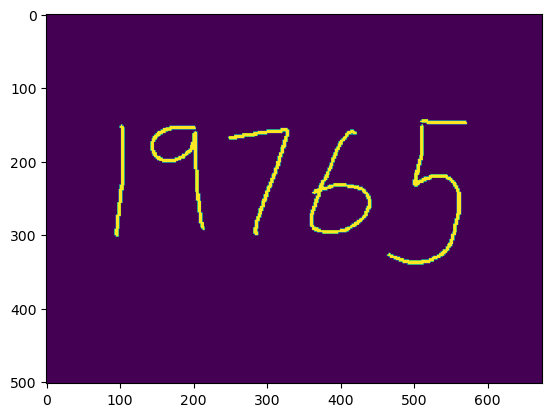

In [111]:
sample = cv2.imread("data/digits/len5.png")
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(sample, 125, 255, cv2.THRESH_BINARY_INV)
# thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
plt.imshow(thresh)

### Contouring

In [112]:
# dilation parameter; bigger tuple = smaller rectangle
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 1))

# apply dilation to the thresholded monochrome image
dilation = cv2.dilate(thresh, rect_kernel, iterations=1)

# find contours and rectangles
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

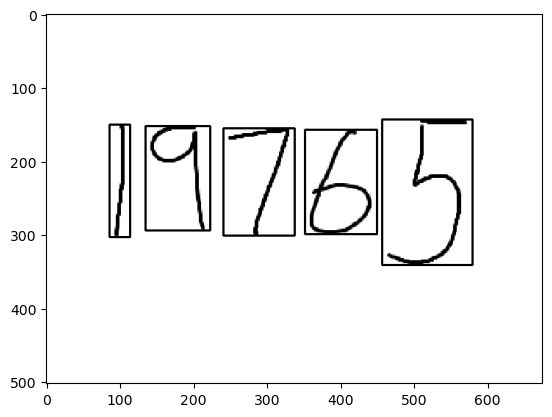

In [113]:
copy = sample.copy()

crops = []
for cnt in contours:
    # get coordinates of contours
    x, y, w, h = cv2.boundingRect(cnt)

    # draw rectangle for each contour
    cv2.rectangle(copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # create crops per contour
    crop = thresh[y:y+h, x:x+w]
    crops.append(crop)

plt.imshow(copy, cmap="gray")

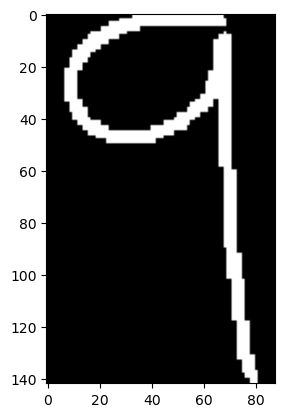

In [114]:
single = crops[2]
plt.imshow(single, cmap="gray")

### Transforms

In [115]:
pil_img = Image.fromarray(single)

In [116]:
transformation = transforms.Compose([
    transforms.Resize(256),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [117]:
post = transformation(pil_img)
pic = post.unsqueeze(dim=0).type(torch.float32).to(device)

### Model Insertion

In [118]:
model = torch.hub.load('pytorch/vision:v0.10.0', "resnet18", pretrained=False)
model.to(device)
load_model(model, "resnet_ocr.safetensors")

Using cache found in C:\Users\paoma/.cache\torch\hub\pytorch_vision_v0.10.0


(set(), [])

In [119]:
model.eval()
with torch.inference_mode():
    results = model(pic)
    results = results[:, :10] # limit to only 10 digits
    pred = results.argmax(dim=1)
    conf = torch.softmax(results, dim=1)[0][pred] * 100

print(f"Predicted Digit: {pred.item()} | Confidence: {conf.item():.2f}%")

Predicted Digit: 1 | Confidence: 99.56%
